In [21]:
!pip install keras_tuner
!pip install wget
!pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import os, warnings
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf
from keras.utils import np_utils
import keras_tuner as kt
from keras.applications.vgg16 import VGG16
import tensorflow_datasets as tfds
import glob
import os
import wget

# Helper Functions

In [23]:
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions )
  plt.figure(figsize=(10,10))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

# Project 2 - Veggie Classification

For this assignment you'll need to classify some images of vegetables. 

## Parts

Please do two separate classifications:
<ol>
<li> First, create a model from scratch. 
<li> Use transfer learning to use a pretrained model of your choice, adapted to this data. 
</ol>

There won't be an explicit evaluation of accuracy, but you should take some steps to make each model as accurate as you reasonably can, any tuning option is fair game. Along with that, please structure it into a notebook that is well structured and clear that explains what you did and found. Think about:
<ul>
<li> Sections and headings. 
<li> A description of the approach taken (e.g. what did you do to determine size, tune, evaluate, etc...)
<li> Visualization of some important things such as a confusion matrix and maybe some images. 
<li> Results, mainly focused on the scoring of the test data. 
</ul>

The descriptions and explainations should highlight the choices you made and why you made them. Figure up to about a page or so worth of text total, explain what happened but don't write an essay. 

## Deliverables

Please sumbmit a link to your github, where everyhting is fully run with all the outputs showing on the page. As well, in the notebook please add some kind of switch controlled by a variable that will control if the notebook runs to train the model or to load the model in from weights - so I can download it and click run all, it will load the saved weights, and predict.

### Dataset

The code in the start of this notebook will download and unzip the dataset, and there is also a simple example of creating datasets. You can change the dataset bit to use a different approach if you'd like. The data is already split into train, validation, and test sets. Please treat the separate test set as the final test set, and don't use it for any training or validation. Each folder name is its own label.

### Evaluation

Marking will be based on the following:
<ul>
<li> Models are cretaed, tuned, and effective at classifying the data: 40%
<li> Descriptions and explanations of the approach taken: 20%
<li> Code is well structured and clear: 20%
</ul>

Overall the marking is pretty simple and direct, walk through the process of predicting the veggies, explain what you did, and show the results. If you do that, it'll get a good mark.

### Tips

Some hints that may be helpful to keep in mind:
<ul>
<li> The data is pretty large, so you'll want to use datasets rather than load everything into memory. The Keras docs have a few examples of different ways to load image data, our examples showed image generators and the image from directory datasets.  
<li> Be careful of batch size, you may hit the colab limits. 
<li> You'll want to use checkpoints so you can let it train and pick up where you left off.
<li> When developing, using a smaller dataset sample is a good idea. These weights could also be saved and loaded to jump start training on the full data. 
<li>

### Training Switch

In [24]:
training = True

### Download and Unzip Data

In [25]:
if training:
    def bar_custom(current, total, width=80):
        print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))
    import wget
    import zipfile
    zip_name = "train.zip"

    url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/vegetable_image_dataset.zip"

    if not os.path.exists(zip_name):
        wget.download(url, zip_name, bar=bar_custom)

    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall()

In [26]:
# Generate Datasets - you can change this if desired
# ENSURE FILE PATHS MATCH CORRECTLY
if training:
    IMAGE_SIZE=(224,224)
    train_dir='Vegetable Images/train'
    val_dir='Vegetable Images/validation'
    batch_size = 16
    BUFFER = 150
    SEED = 42

    # Load training data
    train_ds = image_dataset_from_directory(
        train_dir,
        label_mode='categorical',
        image_size = IMAGE_SIZE,
        batch_size=batch_size,
        seed = SEED
    )

    val_ds = image_dataset_from_directory(
        val_dir,
        label_mode='categorical',
        image_size = IMAGE_SIZE,
        batch_size = batch_size,
        seed = SEED
    )

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Data Preparation

# Helper Functions

In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [28]:
if training:
  BASE_EPOCHS = 20
  BATCH_SIZE = 10
  BASE_PATIENCE = 5
  MIN_DELTA = .02
  MONITOR = "val_accuracy"
  MODE = "max"
  WEIGHT_PATH = "weights/"

  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  if IN_COLAB:
    BASE_EPOCHS = 75
    BATCH_SIZE = 4000
    BASE_PATIENCE = 5

  acc = keras.metrics.CategoricalAccuracy(name="accuracy")
  pre = keras.metrics.Precision(name="precision")
  rec = keras.metrics.Recall(name="recall")
  metric_list = [acc, pre, rec]

  earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, restore_best_weights=True, min_delta=MIN_DELTA, mode=MODE)
  checkpoint_callback_from_scratch = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH + "scratch/" + "weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
  checkpoint_callback_transfer = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH + "transfer/" + "weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')

## Optimizing

In [29]:
train_ds = train_ds.shuffle(buffer_size=BUFFER, seed = SEED)

In [30]:
TPAIN = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=TPAIN)
val_ds = val_ds.prefetch(buffer_size=TPAIN)

## Custom Model Training

In [31]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding="same",  input_shape=(224, 224, 3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, (3,3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Conv2D(128, (3,3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, (3,3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3,3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, (3,3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, (3,3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(512, (3,3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_regularizer="l2"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(128, kernel_regularizer="l2"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(15, activation="sigmoid")
])
model.compile(
  #optimizer=tf.optimizers.Adam(learning_rate=0.001),
  optimizer="rmsprop",
  #loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  loss="categorical_crossentropy",
  metrics=['accuracy']
  )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 re_lu_10 (ReLU)             (None, 224, 224, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 re_lu_11 (ReLU)             (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 128)     73856     
                                                      

weights/scratch/weights.01-0.81.hdf5
Weights found using weights/scratch/weights.01-0.81.hdf5
Epoch 1/75
938/938 [==============================] - ETA: 0s - loss: 1.1096 - accuracy: 0.7277
Epoch 1: val_accuracy improved from -inf to 0.83833, saving model to weights/scratch/weights.01-0.65.hdf5
938/938 [==============================] - 188s 180ms/step - loss: 1.1096 - accuracy: 0.7277 - val_loss: 0.6481 - val_accuracy: 0.8383
Epoch 2/75
938/938 [==============================] - ETA: 0s - loss: 1.1368 - accuracy: 0.7254
Epoch 2: val_accuracy did not improve from 0.83833
938/938 [==============================] - 170s 178ms/step - loss: 1.1368 - accuracy: 0.7254 - val_loss: 0.6778 - val_accuracy: 0.8253
Epoch 3/75
938/938 [==============================] - ETA: 0s - loss: 1.2389 - accuracy: 0.6964
Epoch 3: val_accuracy did not improve from 0.83833
938/938 [==============================] - 169s 179ms/step - loss: 1.2389 - accuracy: 0.6964 - val_loss: 0.8430 - val_accuracy: 0.7897
Epoch

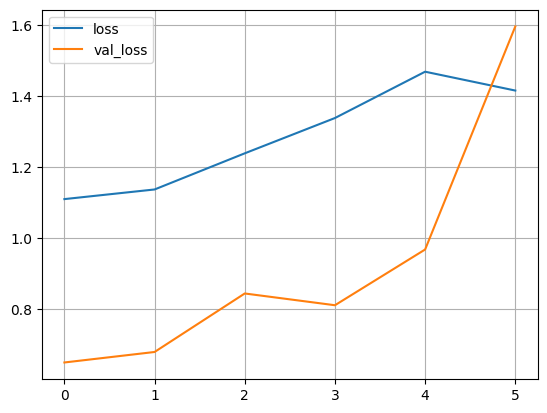

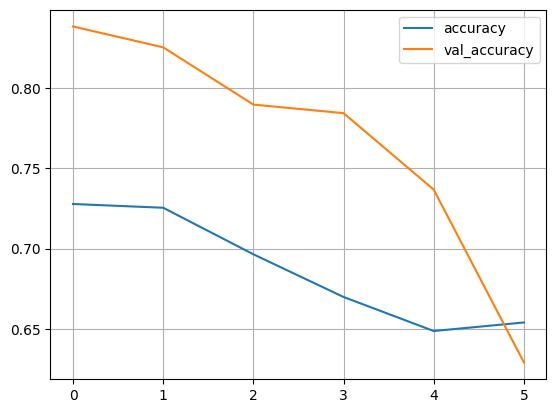

In [32]:
# Train
if training:
  if os.path.exists(WEIGHT_PATH + "scratch/"):
    
    list_of_files = glob.glob(WEIGHT_PATH + "scratch/"+'*.hdf5') # gets all model weights files
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    if latest_file:
      print("Weights found using", latest_file)
      model.load_weights(latest_file)
  log_m1 = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=BASE_EPOCHS,
      callbacks=[earlyStoppingCallback,checkpoint_callback_from_scratch]
  )
  plot_loss(log_m1)
  plot_acc(log_m1)
  model.save('Scratch')

## Transfer Learning Model

In [33]:
#get VGG16 NN

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False ## Not trainable weights

# Add Dense Stuff
flatten_layer = Flatten()
dense_layer_1 = Dense(512, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')
drop_layer_1 = Dropout(.2)
dense_layer_2 = Dense(256, activation='relu', kernel_regularizer='l2', bias_regularizer='l2')
prediction_layer = Dense(15, activation='sigmoid')

tlModel = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_layer_1,
    dense_layer_2,
    prediction_layer
])
tlModel.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=['accuracy'])
tlModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 15)                3855      
                                                                 
Total params: 27,695,439
Trainable params: 12,980,751


Weights found using weights/transfer/weights.01-1.77.hdf5
Epoch 1/75
938/938 [==============================] - ETA: 0s - loss: 1.7092 - accuracy: 0.9204
Epoch 1: val_accuracy improved from -inf to 0.97333, saving model to weights/transfer/weights.01-0.96.hdf5
938/938 [==============================] - 86s 88ms/step - loss: 1.7092 - accuracy: 0.9204 - val_loss: 0.9639 - val_accuracy: 0.9733
Epoch 2/75
938/938 [==============================] - ETA: 0s - loss: 1.1521 - accuracy: 0.9261
Epoch 2: val_accuracy did not improve from 0.97333
938/938 [==============================] - 82s 86ms/step - loss: 1.1521 - accuracy: 0.9261 - val_loss: 0.7373 - val_accuracy: 0.9630
Epoch 3/75
938/938 [==============================] - ETA: 0s - loss: 0.9596 - accuracy: 0.9260
Epoch 3: val_accuracy did not improve from 0.97333
938/938 [==============================] - 82s 86ms/step - loss: 0.9596 - accuracy: 0.9260 - val_loss: 0.9692 - val_accuracy: 0.8990
Epoch 4/75
938/938 [==========================

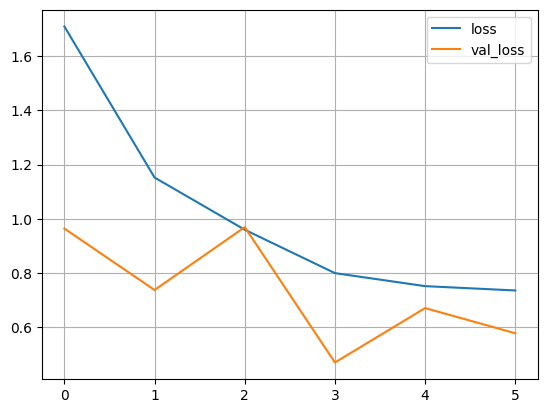

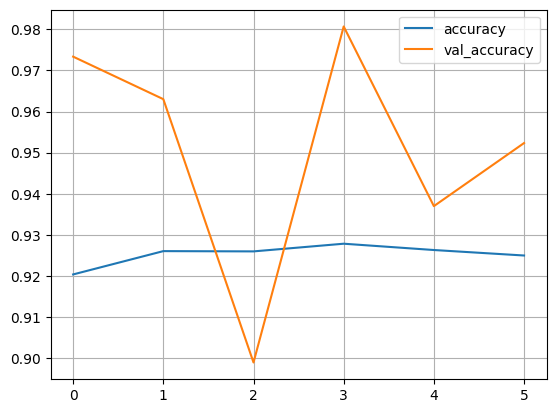

In [34]:
if training:
  if os.path.exists(WEIGHT_PATH + "transfer/"):
    list_of_files = glob.glob(WEIGHT_PATH + "transfer/"+'*.hdf5') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    if latest_file:
      print("Weights found using", latest_file)
      tlModel.load_weights(latest_file)
  log_m2 = tlModel.fit(
      train_ds,
      validation_data=val_ds,
      epochs=BASE_EPOCHS,
      callbacks=[earlyStoppingCallback,checkpoint_callback_transfer]
  )
  plot_loss(log_m2)
  plot_acc(log_m2)
  tlModel.save('Transfer')

## Test Best Models and Illustrate Results

In [35]:
test_dir='Vegetable Images/test'
label_walk = os.walk(test_dir)
labels = []
for path, directories, files in label_walk:
     for directory in directories:
          labels.append(directory)
labels.sort()

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=42, image_size = IMAGE_SIZE, batch_size = batch_size, shuffle=True, labels='inferred', label_mode="categorical", class_names=labels)


Found 3000 files belonging to 15 classes.


In [36]:
# AKEEM WEIGHTS GO HERE
if training == False:
  weightsName = "AdamAndShaun.hdf5"
  weightsUrl = "https://drive.google.com/file/d/1qVjSnxZx7gXrs2V9ekMjg9F7acas4X8r/view?usp=share_link" #our actual weights, if you don't feel like uploading it
  wget.download(weightsUrl, weightsName)

In [37]:
if training == False:
  model.load_weights("/content/weights/scratch/weights.01-0.95.hdf5")

# Comparison

In [38]:
#Get our prediction results

customModelPredictionResults = model.predict(test_ds)
transferModelPredictionResults = tlModel.predict(test_ds)
testLabels = np.concatenate([y for x, y in test_ds], axis=0)

188/188 [==============================] - 13s 70ms/step


# Confusion Matrix Scratch Model

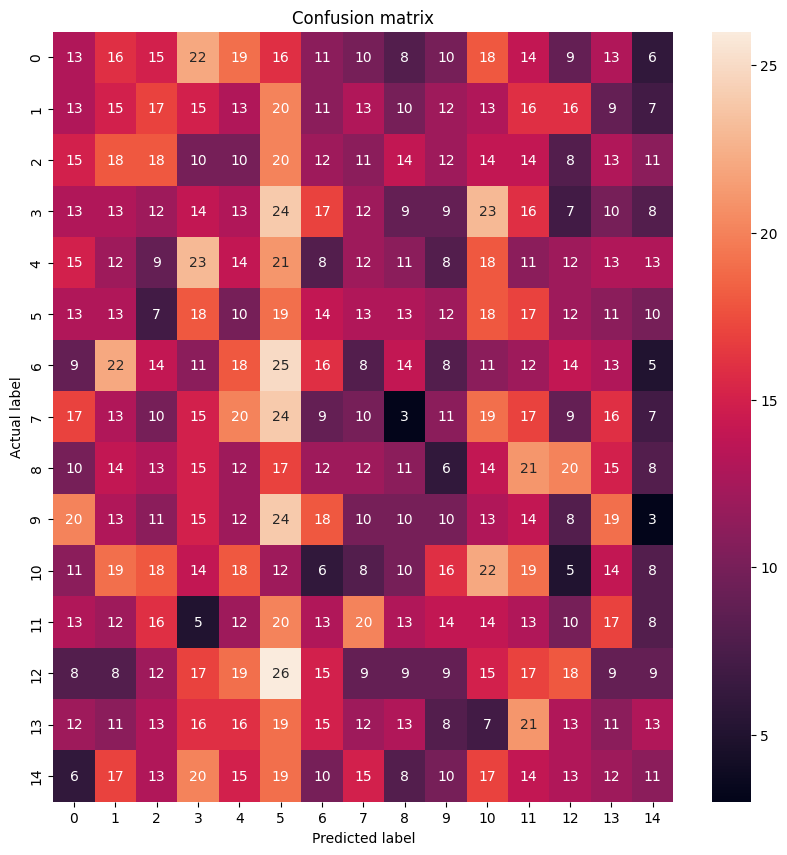

In [39]:
plot_cm(np.argmax(testLabels, axis=-1),np.argmax(customModelPredictionResults, axis=-1))

In [40]:
customModelPredictionResults

array([[8.5175999e-02, 1.0894655e-06, 5.4464505e-07, ..., 3.4537952e-18,
        1.4963570e-24, 3.8394796e-15],
       [8.4843726e-14, 7.3701295e-10, 4.2822768e-19, ..., 5.5774443e-02,
        1.8376470e-08, 9.8787627e-09],
       [6.0317554e-03, 2.7442666e-02, 4.4758711e-04, ..., 9.3542682e-03,
        3.5023883e-02, 7.9404342e-04],
       ...,
       [1.8126597e-07, 5.2911664e-06, 4.9795577e-11, ..., 1.0159345e-06,
        8.8341197e-04, 3.2904299e-09],
       [2.5168267e-18, 3.8658082e-19, 8.1316296e-28, ..., 3.5719146e-15,
        3.2726535e-07, 7.0342917e-17],
       [8.5667691e-25, 1.4077880e-27, 1.5689915e-35, ..., 9.6882144e-19,
        4.3124018e-10, 8.4803259e-22]], dtype=float32)

# Confusion Matrix Transfer Model 

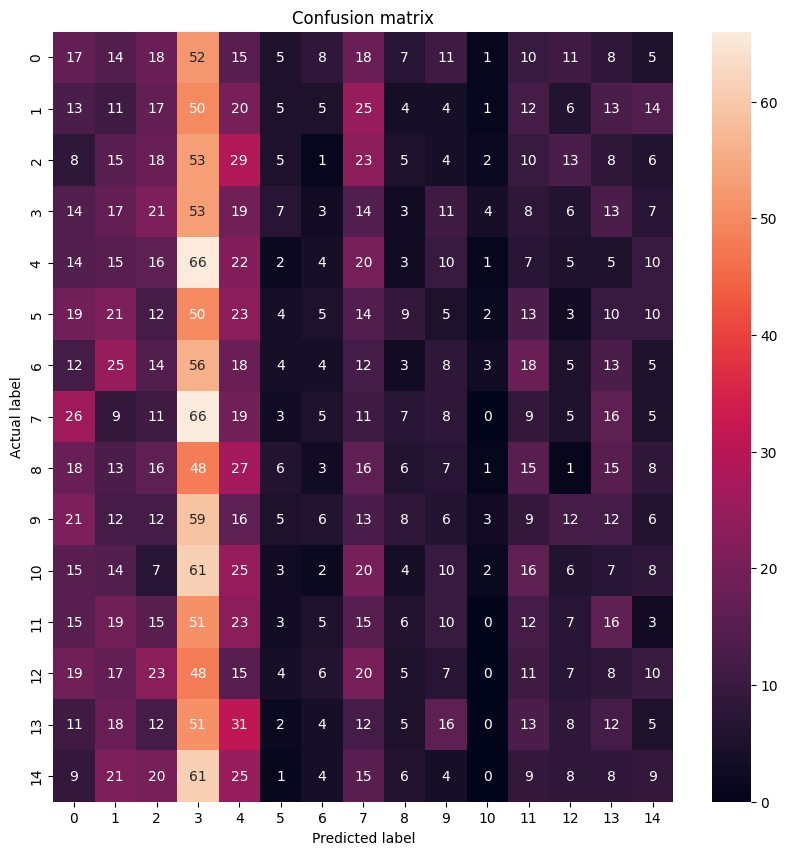

In [41]:
plot_cm(np.argmax(testLabels, axis=-1),np.argmax(transferModelPredictionResults, axis=-1))

# Approach Taken
To be able to iterate and check the effectivness of our changes we ran our models on 150 images in the train dataset and 30 in the validation dataset.

This allowed us to make changes and quickly rerun, and the model seemed to scale up nicely.
## From Scratch Model
A model was made from scratch we started with something from the class notebooks. We then worked on getting the model more accurate while still being fast enough that we wouldn't grow old and die before getting an accuracy score. 
### Making it faster
1. Used prefetch with autotune so that the CPU and GPU are both busy
2. shuffle so that we're not usig all 15000 files at once

### Making it more accurate
1. We added more layers to our model specifically unpooled convolutional layers
2. changed from leaky relu to relu, no specific thing jumped out, but when the change was made the accuracy improved
3. less regularization (removed one dropout), we weren't particularily over fitted so it seemed reasonable to remove one of our dropout layers

##Transfer Model
We used VGG16 as our transfer model and made our own top with a few dense layers and a dropout. The accuracy for this was extremely high without having to do much tuning.